# Machine Learning Zoomcamp 2025 – Midterm Project

### Student: Yee Mon Thant


In [107]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

**Dataset**

In [83]:
import requests

url = "https://raw.githubusercontent.com/plotly/datasets/master/diabetes.csv"

r = requests.get(url)

with open("diabetes.csv", "wb") as f:
    f.write(r.content)

print("Downloaded diabetes.csv")


Downloaded diabetes.csv


**Data Preparation**

In [84]:
df = pd.read_csv("diabetes.csv")

import re

df.columns = (
    df.columns
    .str.replace('([a-z])([A-Z])', r'\1_\2', regex=True)  # add underscore between camelCase
    .str.replace(' ', '_')                                # replace spaces if any
    .str.lower()                                          # lowercase
)

df.head(2)

,pregnancies,glucose,blood_pressure,skin_thickness,insulin,bmi,diabetes_pedigree_function,age,outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0


**EDA, Feature Important Analysis**

In [85]:
df.dtypes

,0
pregnancies,int64
glucose,int64
blood_pressure,int64
skin_thickness,int64
insulin,int64
bmi,float64
diabetes_pedigree_function,float64
age,int64
outcome,int64


In [86]:
df.isnull().sum()

,0
pregnancies,0
glucose,0
blood_pressure,0
skin_thickness,0
insulin,0
bmi,0
diabetes_pedigree_function,0
age,0
outcome,0


<Axes: xlabel='bmi', ylabel='Count'>

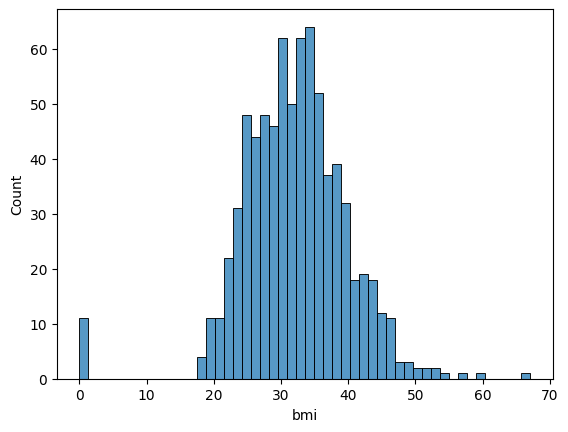

In [87]:
sns.histplot(df.bmi, bins=50)

In [88]:
df_full_train,df_test = train_test_split(df, test_size = 0.2, random_state = 42) #test size = 20%
df_train, df_val = train_test_split(df_full_train, test_size = 0.25, random_state = 42) # 20/80 = 25%

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.outcome.values
y_val = df_val.outcome.values
y_test = df_test.outcome.values

del df_train['outcome']
del df_val['outcome']
del df_test['outcome']

In [89]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [90]:
y_train = df_train.outcome.values
y_val = df_val.outcome.values
y_test = df_test.outcome.values

del df_train['outcome']
del df_val['outcome']
del df_test['outcome']

In [91]:
def train(df_train, y_train, C=1.0):
    dicts = df_train.to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=1000, random_state=42)
    model.fit(X_train, y_train)

    return dv, model

In [92]:
def predict(df, dv, model):
    dicts = df.to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [93]:
dv, model = train(df_train, y_train, C=1.0)
y_pred = predict(df_val, dv, model)
baseline_accuracy = (y_val == (y_pred >= 0.5)).mean().round(2)
print(baseline_accuracy)

0.79


In [94]:
dv = DictVectorizer(sparse=False)

features = df.columns.drop('outcome')

for feature in features:
    train_dict = df_train.drop(feature, axis=1).to_dict(orient='records')
    X_train = dv.fit_transform(train_dict)

    val_dict = df_val.drop(feature, axis=1).to_dict(orient='records')
    X_val = dv.transform(val_dict)

    model = LogisticRegression(C=1.0, max_iter=1000, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict_proba(X_val)[:, 1]

    accuracy = (y_val == (y_pred >= 0.5)).mean().round(2)
    accuracy_diff = (baseline_accuracy - accuracy).round(2)
    print(f'Accuracy difference after eliminating {feature}: {accuracy_diff}')

Accuracy difference after eliminating pregnancies: 0.02
Accuracy difference after eliminating glucose: 0.08
Accuracy difference after eliminating blood_pressure: -0.01
Accuracy difference after eliminating skin_thickness: 0.02
Accuracy difference after eliminating insulin: 0.02
Accuracy difference after eliminating bmi: 0.06
Accuracy difference after eliminating diabetes_pedigree_function: 0.01
Accuracy difference after eliminating age: 0.01


In [95]:
auc_scores = {}

for feature in features:
    feature_values = df_train[feature].values
    auc = roc_auc_score(y_train, feature_values)

    if auc < 0.5:
        auc = roc_auc_score(y_train, -feature_values)
    auc_scores[feature] = auc

print("AUC scores for numerical features:")
for feature, score in auc_scores.items():
    print(f"{feature}: {score:.4f}")

best_feature = max(auc_scores, key=auc_scores.get)
print(f"\nThe numerical feature with the highest AUC is: {best_feature}")

AUC scores for numerical features:
pregnancies: 0.6423
glucose: 0.7648
blood_pressure: 0.5622
skin_thickness: 0.5521
insulin: 0.5250
bmi: 0.6852
diabetes_pedigree_function: 0.5821
age: 0.7341

The numerical feature with the highest AUC is: glucose


**Model Selection Process and Parameter Tuning**

In [101]:
def select_best_C(df_full_train, y_full_train, C_values=None, n_splits=5, random_state=42):
    if C_values is None:
        C_values = [1e-6, 1e-4, 0.001, 0.01, 0.1, 1, 10, 100]

    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    results = {}

    for c in C_values:
        auc_scores = []
        for train_idx, val_idx in kfold.split(df_full_train):
            df_train = df_full_train.iloc[train_idx]
            df_val = df_full_train.iloc[val_idx]

            y_train = y_full_train[train_idx]
            y_val = y_full_train[val_idx]

            dv, model = train(df_train, y_train, C=c)
            y_pred = predict(df_val, dv, model)

            auc_scores.append(roc_auc_score(y_val, y_pred))

        mean_auc = np.mean(auc_scores)
        std_auc = np.std(auc_scores)
        results[c] = (mean_auc, std_auc)
        print(f"C={c:<10} ROC AUC: {mean_auc:.3f}")
        print(f"The standard deviation of the scores across different folds is: {std_auc:.3f}\n")

    best_C = max(results, key=lambda k: results[k][0])
    print(f"Best C based on CV: {best_C}")

    return best_C, results


In [103]:
best_C, results = select_best_C(df_full_train, y_full_train)


C=1e-06      ROC AUC: 0.734
The standard deviation of the scores across different folds is: 0.036

C=0.0001     ROC AUC: 0.812
The standard deviation of the scores across different folds is: 0.020

C=0.001      ROC AUC: 0.822
The standard deviation of the scores across different folds is: 0.023

C=0.01       ROC AUC: 0.823
The standard deviation of the scores across different folds is: 0.022

C=0.1        ROC AUC: 0.826
The standard deviation of the scores across different folds is: 0.023

C=1          ROC AUC: 0.828
The standard deviation of the scores across different folds is: 0.024

C=10         ROC AUC: 0.828
The standard deviation of the scores across different folds is: 0.024

C=100        ROC AUC: 0.828
The standard deviation of the scores across different folds is: 0.024

Best C based on CV: 100


**Final Model**

In [105]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

df_full_train = df_full_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_full_train = df_full_train.outcome.values
y_test = df_test.outcome.values

df_full_train = df_full_train.drop('outcome', axis=1)
df_test = df_test.drop('outcome', axis=1)

dv, model = train(df_full_train, y_full_train, C=best_C)
y_pred = predict(df_test, dv, model)

auc = roc_auc_score(y_test, y_pred)
print(f"Test set ROC AUC: {auc:.3f}")

Test set ROC AUC: 0.814


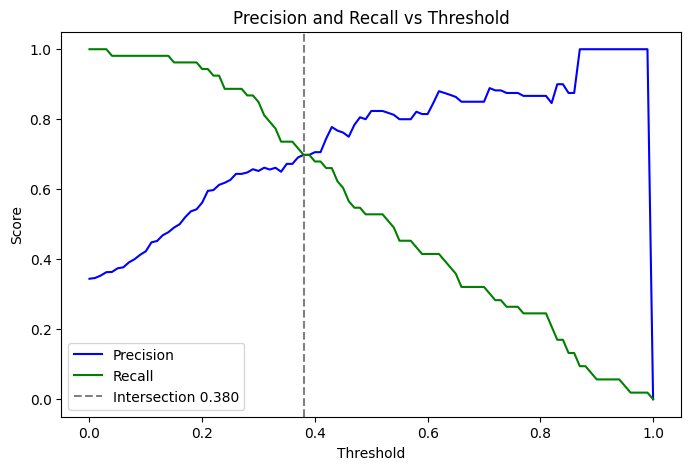

In [111]:
thresholds = np.arange(0.0, 1.01, 0.01)

scores = []

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    # Avoid division by zero
    p = tp / (tp + fp) if (tp + fp) > 0 else 0
    r = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (p * r) / (p + r) if (p + r) > 0 else 0

    scores.append((t, p, r, f1))

columns = ['thresholds', 'precision', 'recall', 'f1 score']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['diff'] = abs(df_scores['precision'] - df_scores['recall'])
intersection_threshold = df_scores.loc[df_scores['diff'].idxmin(), 'thresholds']

plt.figure(figsize=(8,5))
plt.plot(df_scores.thresholds, df_scores['precision'], label='Precision', color='blue')
plt.plot(df_scores.thresholds, df_scores['recall'], label='Recall', color='green')
plt.axvline(intersection_threshold, color='gray', linestyle='--', label=f'Intersection {intersection_threshold:.3f}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')
plt.legend()
plt.show()
